In [29]:
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

import os
import pandas as pd
import torch
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils.data import GeneFeatureDataset, seq_concat, select_cols
from utils.model import GeneInteractionModel
from utils.loss import BalancedMSELoss

import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from itertools import combinations

pd.options.mode.chained_assignment = None  # default='warn'

In [160]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# Create test/train splits for 5 models

In [79]:
finetune_data = pd.read_csv('../easy_prime/figure_rep/DeepPrime_ForFT_withGenes.csv')
finetune_data

,gene,ID,WT74_On,Edited74_On,PBSlen,RTlen,RT-PBSlen,Edit_pos,Edit_len,RHA_len,...,nGCcnt1,nGCcnt2,nGCcnt3,fGCcont1,fGCcont2,fGCcont3,MFE3,MFE4,DeepSpCas9_score,Measured_PE_efficiency
0,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTxxxxxxxxxxxxxxxxx...,13,8,21,5,1,3,...,8,4,12,61.538462,50.000000,57.142857,-1.7,-1.6,65.144363,6.410003
1,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGxxxxxxxxxxxxxxxx...,13,9,22,5,1,4,...,8,5,13,61.538462,55.555556,59.090909,-1.7,-1.6,65.144363,0.919506
2,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGAxxxxxxxxxxxxxxx...,13,10,23,5,1,5,...,8,5,13,61.538462,50.000000,56.521739,-1.7,-1.6,65.144363,5.100177
3,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACxxxxxxxxxxxxxx...,13,11,24,5,1,6,...,8,6,14,61.538462,54.545455,58.333333,-1.7,-1.6,65.144363,9.992335
4,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACGxxxxxxxxxxxxx...,13,12,25,5,1,7,...,8,7,15,61.538462,58.333333,60.000000,-1.7,-1.6,65.144363,3.479796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,15,11,26,1,1,10,...,5,5,10,33.333333,45.454545,38.461538,-1.1,0.0,52.229725,3.630080
195,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,15,11,26,1,1,10,...,5,5,10,33.333333,45.454545,38.461538,-1.1,0.0,52.229725,6.989605
196,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxTCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,16,11,27,1,1,10,...,5,5,10,31.250000,45.454545,37.037037,-1.6,0.0,52.229725,3.022388
197,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxGTCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,17,11,28,1,1,10,...,6,5,11,35.294118,45.454545,39.285714,-1.5,0.0,52.229725,2.146368


### At the end of this section, you have 5 different splits of test/train data. In each of the test sets, there is roughly equal representation across all the 8 genes. Additionally, if you concatenate all the test sets together across all 5 models, you will get all the 199 points. Additionally, each test/train pair contains all 199 points.

In [72]:
genes = ['RNF2', 'EMX1', 'VEGFA', 'HEK3', 'FANCF', 'DNMT1', 'HEK4', 'RUNX1']

# Define the number of splits
num_splits = 5

# Initialize StratifiedKFold to ensure balanced splitting
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Combine all gene indices into a single list
all_gene_indices = np.concatenate(list(gene_indices.values()))


# Create labels for each gene based on their indices
gene_labels = np.zeros(len(all_gene_indices))
for i, gene_name in enumerate(gene_indices.keys()):
    gene_labels[gene_indices[gene_name]] = i

# List to store train/test splits
train_test_splits = []

# Iterate over the splits
for train_index, test_index in skf.split(all_gene_indices, gene_labels):
    # Initialize lists to store indices for train and test sets
    train_indices = []
    test_indices = []
    
    # Split each gene's data separately
    for gene_name, indices in gene_indices.items():
        
        # Divide the indices into train and test sets
        gene_train_index = np.intersect1d(train_index, indices)
        gene_test_index = np.intersect1d(test_index, indices)
        
        # Add the indices to the respective lists
        train_indices.extend(gene_train_index)
        test_indices.extend(gene_test_index)
    
    # Shuffle the indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    

    # Append the train/test indices split to the list
    train_test_splits.append((train_indices, test_indices))


159 40
159 40
159 40
159 40
160 39


In [117]:
for split in train_test_splits:
    train = split[0]
    test = split[1]
    
    print(len(train), len(test))

159 40
159 40
159 40
159 40
160 39


### Now, for each test/train index split up, I need to:

### - Take 10% of the test data for validation
### - Create x_train, g_train, and y_train
### - Create x_val, g_val, and y_val
### - Create x_test, g_test, and y_test

In [111]:
def get_wrapper(split, num_model):
    
    # Train and test
    train_indices = split[0]
    test_indices = split[1]
    
    # Take 10% of training data for validation and update training
    num_validation_indices = int(0.1 * len(train_indices))  # I want 10% of the indices to be used for validation
    validation_indices = np.random.choice(train_indices, size=num_validation_indices, replace=False)  # Randomly choose 10% of the indices for validation
    train_indices = [index for index in train_indices if index not in validation_indices]  # Remove validation indices from train_indices
    
    #Prepare train
    x_train, g_train, y_train = get_training(finetune_data, train_indices, num_model)
    
    #Prepare validation
    x_validation, g_validation, y_validation = get_validation(finetune_data, validation_indices, num_model)
    
    #Prepare test
    x_test, g_test, y_test = get_testing(finetune_data, test_indices, num_model)
    
    return (x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test)
    

In [112]:
def get_training(dataset, train_indices, num_model):
    
    gene_path_train = 'data/genes/' + 'endogenous_train_' + str(num_model) + '.npy'
    
    train_dataset = finetune_data.loc[train_indices]
    train_dataset = train_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error


    if not os.path.isfile(gene_path_train):
        g_train = seq_concat(train_dataset)
        np.save(gene_path_train, g_train)
    else:
        g_train = np.load(gene_path_train)


    train_features, train_target = select_cols(train_dataset)  #Trained target features 
    train_type = train_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_train = (train_features - mean) / std
    y_train = train_target
    y_train = pd.concat([y_train, train_type], axis=1)

    g_train = torch.tensor(g_train, dtype=torch.float32, device=device)
    x_train = torch.tensor(x_train.to_numpy(), dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_train, g_train, y_train])

In [106]:
def get_validation(dataset, validation_indices, num_model):
    
    gene_path_validation = 'data/genes/' + 'endogenous_val_' + str(num_model) + '.npy'
    
    validation_dataset = finetune_data.loc[validation_indices]
    validation_dataset = validation_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error


    if not os.path.isfile(gene_path_validation):
        g_validation = seq_concat(validation_dataset)
        np.save(gene_path_validation, g_validation)
    else:
        g_validation = np.load(gene_path_validation)


    validation_features, validation_target = select_cols(validation_dataset)  
    validation_type = validation_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_validation = (validation_features - mean) / std
    y_validation = validation_target
    y_validation = pd.concat([y_validation, validation_type], axis=1)

    g_validation = torch.tensor(g_validation, dtype=torch.float32, device=device)
    x_validation = torch.tensor(x_validation.to_numpy(), dtype=torch.float32, device=device)
    y_validation = torch.tensor(y_validation.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_validation, g_validation, y_validation])

In [113]:
def get_testing(dataset, test_indices, num_model):
    

    gene_path_test = 'data/genes/' + 'endogenous_test' +  str(num_model) +'.npy'
    
    test_dataset = finetune_data.loc[test_indices]
    test_dataset = test_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error

    if not os.path.isfile(gene_path_test):
        g_test = seq_concat(test_dataset)
        np.save(gene_path_test, g_test)
    else:
        g_test = np.load(gene_path_test)

    test_features, test_target = select_cols(test_dataset)  #Test target features 
    test_type = test_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_test = (test_features - mean) / std
    y_test = test_target
    y_test = pd.concat([y_test, test_type], axis=1)

    g_test = torch.tensor(g_test, dtype=torch.float32, device=device)
    x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_test, g_test, y_test])

# Hyperparameter Optimization

In [114]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import optuna
import time
from optuna.trial import TrialState

In [127]:
class Optuna_Trainer:
    
    # Initializing attributes including training and testing sets g (one-hot encoding of input sequences), x (features), and y (Measured editing efficiencies).
    def __init__(self, model, x_train, g_train, y_train, x_y_validation, g_y_validation, y_validation): 
        self.g_train = g_train   # Training data for g
        self.x_train = x_train   # Training data for x 
        self.y_train = y_train   # Training data for y
        self.g_val = g_validation       # Validation data for g
        self.x_val = x_validation       # Validation data for x
        self.y_val = y_validation       # Validation data for y
        self.model = model       # Call machine learning model as an attribute of the object
        self.lr = 1e-5           # Learning rate
        self.wd = 1e-5           # Weight decay: Weight decay should typically be same value as the learning rate
        self.bs = 8              # Batch size 
        self.ep = 100            # Number of epochs
        
        # Patience represents the number of consecutive trials where the validation loss does not decrease (performance is not improved).
        self.patience = 20       # Changing patience value to 20. 
        self.delta = 1e-4        # Delta is the threshold needed for the difference between the previous minimum loss and the validation loss.

    # Set up hyperparameter search space
    def setup_trials(self, trial):
        
        #Parameters that need to be searched
        self.lr = trial.suggest_categorical("lr", [1e-4,1e-3,2e-3,5e-3, 1e-2])   # Categorical values for learning rate
        self.wd = self.lr                                                        # Assign weight decay to be the same as the learning rate
        self.bs = trial.suggest_categorical("batch_size", [8, 16, 32])           # Categorical values for batch size
        self.ep = trial.suggest_categorical("num_epochs", [50, 100, 200, 500])   # Categorical values for number of epochs
        
        # Fixed parameters
        self.hs = 128                    # Hidden size
        self.nl = 1                      # Number of GRU layers
        self.schedule = True             # Learning rate scheduler
        
        # Print trial hyperparameters
        for key, value in trial.params.items():
            print("{}: {}".format(key, value))
    
    # Trains the DeepPrime model based on the provided testing and training data
    def train_model(self, trial): 
        
        min_loss = None                   #  Stores the minimum loss, initialize with no value
        early_stopping_counter = 0        #  Track how many consecutive epochs have occurred without improvement in the validation loss, used to prevent overfitting.

        #Trial object is created when Optuna generates a study object, so it's not something to explicitly point to
        self.setup_trials(trial) # Sets up the trial with a set of hyperparameters derived from the setup_trials function


        # Prepare the training data to run through the model
        train_dataset = GeneFeatureDataset(self.g_train, self.x_train, self.y_train) 
        train_loader = DataLoader(train_dataset, batch_size=self.bs, shuffle=True, drop_last=True) 

        # Prepare the testing and validation datasets
        val_dataset = GeneFeatureDataset(self.g_val, self.x_val, self.y_val) 
        val_loader = DataLoader(val_dataset, batch_size=self.bs, shuffle=True) # Q: Shuffle?

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd)   # Sets up optimizer, I am also using AdamW
        optimizer.zero_grad()  # Zeroes out gradients, kind of a "hack" where optimization is actually better when gradients are not stored
        
        criterion = BalancedMSELoss() # Loss function used in DeepPrime

        # print("epoch\ttrain_corr\ttrain_loss\ttrue_auc\tpred_auc\tval_corr\tval_loss\telapsed_time")
        for epoch in range(self.ep): # self.ep is the number of epochs, so here we are iterating through the epochs
            
            # Train
            self.model.train()  # Sets model in training mode. Make sure to use self.model because model is now an attribute of the class itself.
            
            train_loss = []    # List that will keep track of the loss across the entire epoch
            train_count = 0    # Number of samples processed in epoch
    

            # Works through each batch of data set up by the train_loader
            for i, (g_batch, x_batch, y_batch) in enumerate(train_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda() # We are on GPU, so move tensors to GPU

                # Update values for all three tensors. Following permutations used in DeepPrime.
                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)


                optimizer.zero_grad()  #Zero out gradient for each batch

                output = self.model(g_batch, x_batch) # Send g and x through the model

                total_loss = criterion(output, y_batch) # Calculate the loss between the model output and the actual measured efficiencies

                total_loss.backward() # Computes gradients of the loss with repsect to the model parameters
                optimizer.step()  # Applies optimization to update parameters

                train_loss.append(x_batch.size(0) * total_loss.detach().cpu().numpy()) # Multiplies batch-loss by batch size to normalize for different sized batches during training
                train_count += x_batch.size(0)  # Updates number of samples processed in the epoch

            train_loss = sum(train_loss) / train_count  # train_loss now represents the average training loss across batches for the ENTIRE epoch


            # Validation
            self.model.eval()  # Set model in evaluation mode
            
            val_loss = []
            val_count = 0

            # Same as with training batches
            for i, (g_batch, x_batch, y_batch) in enumerate(val_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda()

                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)
                
                output = self.model(g_batch, x_batch)  #Run validation data through model

                loss = criterion(output, y_batch)
                
                
                val_loss.append(x_batch.size(0) * loss.detach().cpu().numpy())
                val_count += x_batch.size(0)

            val_loss = sum(val_loss) / val_count


            # Summary of training progress
            # print("{}\t{:.4f}\t{:.4f}".format(epoch, train_loss, val_loss))

            trial.report(val_loss, epoch) # Reports the result of the current epoch to Optuna, so Optuna can keep track of model performance throughout the trial.
            

            if min_loss is None:
                min_loss = val_loss  
            elif min_loss - val_loss > self.delta:                    # If the difference between the previous minimum loss and the current validation loss is greater than delta, update values
                min_loss = val_loss                                   # Set the new minimum loss to current validation loss
                early_stopping_counter = 0                            # Reset to 0, indicating no consecutive epochs with increasing validation loss.
            elif min_loss - val_loss < self.delta:                    # No improvement in validation loss
                early_stopping_counter += 1                           # Consecutive epoch for which there is no improvement on validation loss
                if early_stopping_counter >= self.patience:           # At this point, further training is unlikely to improve/lower validation loss, so break
                    break

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return val_loss # #Returns the loss across the epochs, as this is the value we want to minimize

    def exec_study(self):
        study = optuna.create_study()                      # Creates Optuna study object, maximizing correlation
        study.optimize(self.train_model, n_trials=30)      # Runs train_model function n_trials times
        return self.print_result(study)                    # Prints out hyperparameters used for combination that generated lowest validation loss.
    
    def print_result(self, study):
        pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
        complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

        print("Study statistics:")
        print("Number of finished trials:", len(study.trials))
        print("Number of pruned trials:", len(pruned_trials))
        print("Number of complete trials:", len(complete_trials))

        print("Best trial:")
        best_trial = study.best_trial

        print("Value: ", best_trial.value)

        best_params = {}
        print("Params:")
        for key, value in best_trial.params.items():
            print("{}: {}".format(key, value))
            best_params[key] = value
        for key, value in best_trial.user_attrs.items():
            print("{}: {}".format(key, value))
            best_params[key] = value

        return best_params


In [128]:
# Run Optuna_Trainer

n_models = 5

for m in range(n_models):
    print(f"Training Model {m}")
    
    #Get the necessary information
    split = train_test_splits[m]   #There are the same number of splits as there are models
    x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test = get_wrapper(split, m)
    
    
    # Set random seed
    random_seed = m
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    
    print(device)

    # Load pre-trained model
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)  # Model
    model.load_state_dict(torch.load('models/ontarget/final/model_{}.pt'.format(m % 5)))  # Loads weights, biases from this pre-trained model

    # Create a Trainer instance for each model
    trainer = Optuna_Trainer(model, x_train, g_train, y_train, x_validation, g_validation, y_validation)

    # Execute hyperparameter study
    trainer.exec_study()

    print(f"Model {m} complete.")

[I 2024-02-26 11:18:39,349] A new study created in memory with name: no-name-2a607693-80a6-48f6-a61a-a9c5ceb153ae


Training Model 0
cuda:0
lr: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:18:40,595] Trial 0 finished with value: 4.1349592208862305 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 0 with value: 4.1349592208862305.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:18:48,511] Trial 1 finished with value: 1.349531928698222 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 1 with value: 1.349531928698222.


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:18:49,811] Trial 2 finished with value: 0.7784639596939087 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 2 with value: 0.7784639596939087.


lr: 0.002
batch_size: 16
num_epochs: 200


[I 2024-02-26 11:18:51,297] Trial 3 finished with value: 0.8831098675727844 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 200}. Best is trial 2 with value: 0.7784639596939087.


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:18:52,366] Trial 4 finished with value: 0.6742392182350159 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 4 with value: 0.6742392182350159.


lr: 0.005
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:18:53,855] Trial 5 finished with value: 0.6510604619979858 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 50}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.005
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:18:58,921] Trial 6 finished with value: 0.7581716616948445 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:19:03,237] Trial 7 finished with value: 0.6520135243733723 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.001
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:19:06,463] Trial 8 finished with value: 0.7448562423388163 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.002
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:19:09,641] Trial 9 finished with value: 0.7865137259165446 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.005
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:19:11,389] Trial 10 finished with value: 0.8055393695831299 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 50}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.0001
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:19:15,810] Trial 11 finished with value: 0.7168334126472473 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.005
batch_size: 8
num_epochs: 50


[I 2024-02-26 11:19:19,018] Trial 12 finished with value: 0.8903219064076742 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 50}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.01
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:19:21,706] Trial 13 finished with value: 0.7448946833610535 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 50}. Best is trial 5 with value: 0.6510604619979858.


lr: 0.001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:19:22,960] Trial 14 finished with value: 0.6374346017837524 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:19:24,208] Trial 15 finished with value: 0.6608200073242188 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:19:25,450] Trial 16 finished with value: 0.6755653619766235 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:19:26,158] Trial 17 finished with value: 0.693601667881012 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:19:27,341] Trial 18 finished with value: 0.7198883295059204 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:19:29,082] Trial 19 pruned. 


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:19:29,791] Trial 20 pruned. 


lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:19:34,025] Trial 21 pruned. 


lr: 0.0001
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:19:37,887] Trial 22 finished with value: 0.7600034475326538 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.01
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:19:41,113] Trial 23 finished with value: 0.9899554093678792 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:19:43,916] Trial 24 finished with value: 0.6670414209365845 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.005
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:19:50,148] Trial 25 finished with value: 0.7348004062970479 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 100}. Best is trial 14 with value: 0.6374346017837524.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:19:51,594] Trial 26 finished with value: 0.6094299554824829 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 26 with value: 0.6094299554824829.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:19:52,501] Trial 27 finished with value: 0.5815373063087463 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 27 with value: 0.5815373063087463.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:19:53,467] Trial 28 finished with value: 0.5730008482933044 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 28 with value: 0.5730008482933044.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:19:54,378] Trial 29 finished with value: 0.5692780613899231 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 29 with value: 0.5692780613899231.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 3
Number of complete trials: 27
Best trial:
Value:  0.5692780613899231
Params:
lr: 0.0001
batch_size: 32
num_epochs: 50
Model 0 complete.
Training Model 1
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 2343.91it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 1695.66it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(15,) 15 74


100%|██████████| 15/15 [00:00<00:00, 2271.78it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(15,) 15 74


100%|██████████| 15/15 [00:00<00:00, 1688.26it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2283.42it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1665.86it/s]


Preprocessed the sequence
cuda:0


[I 2024-02-26 11:19:54,734] A new study created in memory with name: no-name-e1fe9c5a-213d-4f43-b587-01f4c54309b6


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:20:09,471] Trial 0 finished with value: 0.7970897515614828 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 0 with value: 0.7970897515614828.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:20:10,280] Trial 1 finished with value: 0.329802542924881 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 1 with value: 0.329802542924881.


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:20:14,170] Trial 2 finished with value: 0.28826971848805744 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 2 with value: 0.28826971848805744.


lr: 0.002
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:20:18,009] Trial 3 finished with value: 0.20552277565002441 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 100}. Best is trial 3 with value: 0.20552277565002441.


lr: 0.01
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:20:26,423] Trial 4 finished with value: 0.23683613340059917 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 100}. Best is trial 3 with value: 0.20552277565002441.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:20:27,215] Trial 5 finished with value: 0.1629093885421753 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.1629093885421753.


lr: 0.0001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:20:28,437] Trial 6 finished with value: 0.16101357340812683 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 11:20:29,783] Trial 7 finished with value: 0.4094410538673401 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:31,202] Trial 8 finished with value: 0.18964917957782745 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.01
batch_size: 8
num_epochs: 50


[I 2024-02-26 11:20:33,599] Trial 9 finished with value: 0.27737709681193035 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:20:36,109] Trial 10 finished with value: 0.24865135550498962 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:20:36,823] Trial 11 finished with value: 0.1779051423072815 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:38,250] Trial 12 finished with value: 0.1652822196483612 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:20:40,361] Trial 13 finished with value: 0.18049532175064087 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:41,570] Trial 14 finished with value: 0.1667007952928543 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.002
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:20:44,811] Trial 15 finished with value: 0.1782819777727127 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:20:46,603] Trial 16 finished with value: 0.1742606908082962 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:20:48,749] Trial 17 finished with value: 0.18488802015781403 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 100}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:20:50,124] Trial 18 finished with value: 0.1870318204164505 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:50,762] Trial 19 finished with value: 0.19511643052101135 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:20:51,914] Trial 20 finished with value: 0.1716073602437973 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:53,037] Trial 21 finished with value: 0.16290993988513947 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:54,196] Trial 22 finished with value: 0.17837096750736237 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:55,307] Trial 23 finished with value: 0.1636522263288498 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:20:56,419] Trial 24 finished with value: 0.19715450704097748 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:20:58,942] Trial 25 finished with value: 0.20451900362968445 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:21:00,709] Trial 26 finished with value: 0.1931740790605545 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:21:01,848] Trial 27 finished with value: 0.17241480946540833 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.005
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:21:03,320] Trial 28 finished with value: 0.21408851444721222 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 50}. Best is trial 6 with value: 0.16101357340812683.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:21:05,769] Trial 29 finished with value: 0.21404676338036854 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 6 with value: 0.16101357340812683.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 0
Number of complete trials: 30
Best trial:
Value:  0.16101357340812683
Params:
lr: 0.0001
batch_size: 16
num_epochs: 50
Model 1 complete.
Training Model 2
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 2286.07it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 1621.53it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(15,) 15 74


100%|██████████| 15/15 [00:00<00:00, 2252.50it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(15,) 15 74


100%|██████████| 15/15 [00:00<00:00, 1608.86it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2195.28it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1647.47it/s]


Preprocessed the sequence
cuda:0


[I 2024-02-26 11:21:06,151] A new study created in memory with name: no-name-5b242ef9-4ac3-4937-b191-51c4a0874810


lr: 0.001
batch_size: 8
num_epochs: 50


[I 2024-02-26 11:21:11,875] Trial 0 finished with value: 0.13940040866533915 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 50}. Best is trial 0 with value: 0.13940040866533915.


lr: 0.001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:21:12,917] Trial 1 finished with value: 0.15874174237251282 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 0 with value: 0.13940040866533915.


lr: 0.002
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:21:18,787] Trial 2 finished with value: 0.20570078492164612 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 100}. Best is trial 0 with value: 0.13940040866533915.


lr: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:21:20,874] Trial 3 finished with value: 0.13936717808246613 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 3 with value: 0.13936717808246613.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:21:22,138] Trial 4 finished with value: 0.16730935871601105 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 3 with value: 0.13936717808246613.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:21:24,888] Trial 5 pruned. 


lr: 0.001
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:21:30,662] Trial 6 finished with value: 0.13539969424406686 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.002
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:21:36,501] Trial 7 finished with value: 0.1554642915725708 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 100}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.001
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:21:37,099] Trial 8 finished with value: 0.1631571650505066 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.001
batch_size: 8
num_epochs: 50


[I 2024-02-26 11:21:42,756] Trial 9 finished with value: 0.1838231787085533 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 50}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:21:45,528] Trial 10 finished with value: 0.15955394506454468 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:21:48,547] Trial 11 finished with value: 0.164797842502594 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:21:51,276] Trial 12 finished with value: 0.1590779423713684 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:21:53,553] Trial 13 finished with value: 0.21344751119613647 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 6 with value: 0.13539969424406686.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:21:56,173] Trial 14 finished with value: 0.10888247191905975 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:22:01,090] Trial 15 finished with value: 0.21867230534553528 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:22:02,319] Trial 16 finished with value: 0.15168295800685883 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:22:08,257] Trial 17 finished with value: 0.14511077205340067 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:22:11,196] Trial 18 finished with value: 0.14466823637485504 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:13,071] Trial 19 finished with value: 0.11488346755504608 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:14,865] Trial 20 pruned. 


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:15,496] Trial 21 finished with value: 0.1409999132156372 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:16,834] Trial 22 finished with value: 0.1153726875782013 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 14 with value: 0.10888247191905975.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:18,032] Trial 23 finished with value: 0.10842980444431305 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 23 with value: 0.10842980444431305.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:18,659] Trial 24 finished with value: 0.14424817264080048 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 23 with value: 0.10842980444431305.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:19,302] Trial 25 finished with value: 0.1344011425971985 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 23 with value: 0.10842980444431305.


lr: 0.005
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:22:19,942] Trial 26 finished with value: 0.12212434411048889 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 23 with value: 0.10842980444431305.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:22:21,279] Trial 27 finished with value: 0.10143156349658966 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 27 with value: 0.10143156349658966.


lr: 0.01
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:22:22,079] Trial 28 finished with value: 0.1861487776041031 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 50}. Best is trial 27 with value: 0.10143156349658966.


lr: 0.002
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:22:25,052] Trial 29 finished with value: 0.15026144683361053 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 50}. Best is trial 27 with value: 0.10143156349658966.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 2
Number of complete trials: 28
Best trial:
Value:  0.10143156349658966
Params:
lr: 0.005
batch_size: 32
num_epochs: 50
Model 2 complete.
Training Model 3
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 2299.48it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 1648.48it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(15,) 15 74


100%|██████████| 15/15 [00:00<00:00, 2281.00it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(15,) 15 74


100%|██████████| 15/15 [00:00<00:00, 1672.86it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2264.50it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1685.85it/s]


Preprocessed the sequence
cuda:0


[I 2024-02-26 11:22:25,432] A new study created in memory with name: no-name-d8d26d20-5567-4974-8831-4177c46a1f40


lr: 0.0001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:22:26,035] Trial 0 finished with value: 6.057900905609131 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 0 with value: 6.057900905609131.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:22:28,088] Trial 1 finished with value: 0.21159598231315613 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 100}. Best is trial 1 with value: 0.21159598231315613.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:29,827] Trial 2 finished with value: 0.18046361207962036 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:22:30,458] Trial 3 finished with value: 0.19080200791358948 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.0001
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:22:31,809] Trial 4 finished with value: 0.19756731390953064 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:22:34,475] Trial 5 finished with value: 0.20632033745447795 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:22:35,716] Trial 6 finished with value: 0.21652880311012268 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.005
batch_size: 16
num_epochs: 200


[I 2024-02-26 11:22:39,565] Trial 7 finished with value: 0.1838708072900772 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.002
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:22:43,398] Trial 8 finished with value: 0.28874967694282533 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:22:44,067] Trial 9 finished with value: 0.19972838461399078 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.01
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:22:45,403] Trial 10 finished with value: 0.404865562915802 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 50}. Best is trial 2 with value: 0.18046361207962036.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:22:46,658] Trial 11 finished with value: 0.1803358793258667 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 11 with value: 0.1803358793258667.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:22:47,967] Trial 12 finished with value: 0.9543822407722473 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 11 with value: 0.1803358793258667.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:22:49,453] Trial 13 finished with value: 0.1503482460975647 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:22:50,939] Trial 14 finished with value: 0.202781543135643 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:22:53,360] Trial 15 finished with value: 0.190092071890831 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 50}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:22:54,664] Trial 16 finished with value: 0.18381641805171967 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:22:59,140] Trial 17 finished with value: 0.2112882951895396 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:23:01,033] Trial 18 finished with value: 0.2183181196451187 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:23:03,613] Trial 19 finished with value: 0.19520150125026703 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.002
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:23:04,877] Trial 20 finished with value: 0.2510673403739929 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:23:05,835] Trial 21 finished with value: 0.20287233591079712 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:23:06,472] Trial 22 finished with value: 0.21713635325431824 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:23:11,900] Trial 23 finished with value: 0.23629860083262125 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:23:13,299] Trial 24 finished with value: 0.40155452489852905 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.005
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:23:14,429] Trial 25 finished with value: 0.19754914939403534 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:23:16,326] Trial 26 finished with value: 0.4071688950061798 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.01
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:23:18,942] Trial 27 finished with value: 0.23173226416110992 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 50}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.005
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:23:19,593] Trial 28 finished with value: 0.2192879170179367 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 13 with value: 0.1503482460975647.


lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:23:22,198] Trial 29 finished with value: 0.25465669929981233 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 13 with value: 0.1503482460975647.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 0
Number of complete trials: 30
Best trial:
Value:  0.1503482460975647
Params:
lr: 0.01
batch_size: 16
num_epochs: 500
Model 3 complete.
Training Model 4
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 2334.95it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(144,) 144 74


100%|██████████| 144/144 [00:00<00:00, 1711.28it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(16,) 16 74


100%|██████████| 16/16 [00:00<00:00, 2271.03it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(16,) 16 74


100%|██████████| 16/16 [00:00<00:00, 1674.87it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 2331.76it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 1661.25it/s]


Preprocessed the sequence
cuda:0


[I 2024-02-26 11:23:22,554] A new study created in memory with name: no-name-467e7359-bd91-4f60-80a5-1c8eaa3bc7b3


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 11:23:23,150] Trial 0 finished with value: 4.157201766967773 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 0 with value: 4.157201766967773.


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:23:30,612] Trial 1 finished with value: 1.0839467644691467 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 1 with value: 1.0839467644691467.


lr: 0.01
batch_size: 8
num_epochs: 50


[I 2024-02-26 11:23:36,305] Trial 2 finished with value: 0.147898830473423 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 50}. Best is trial 2 with value: 0.147898830473423.


lr: 0.005
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:23:41,976] Trial 3 finished with value: 0.13544877618551254 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 3 with value: 0.13544877618551254.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:23:44,803] Trial 4 finished with value: 0.12236564978957176 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 4 with value: 0.12236564978957176.


lr: 0.0001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:23:45,659] Trial 5 finished with value: 0.11651873588562012 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:23:47,111] Trial 6 finished with value: 0.12376357614994049 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:23:48,387] Trial 7 finished with value: 0.15430903434753418 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 50}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.005
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:23:50,875] Trial 8 finished with value: 0.12146349623799324 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 11:23:51,524] Trial 9 finished with value: 0.2399459034204483 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.002
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:23:52,344] Trial 10 pruned. 


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:23:53,052] Trial 11 pruned. 


lr: 0.005
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:23:56,197] Trial 12 finished with value: 0.13331548124551773 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 100}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.002
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:23:56,821] Trial 13 finished with value: 0.16539838910102844 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 11:23:58,318] Trial 14 pruned. 


lr: 0.005
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:24:02,457] Trial 15 finished with value: 0.2783767059445381 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:24:03,196] Trial 16 pruned. 


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:24:06,866] Trial 17 pruned. 


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 11:24:08,414] Trial 18 finished with value: 0.2651669979095459 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.002
batch_size: 16
num_epochs: 500


[I 2024-02-26 11:24:09,988] Trial 19 finished with value: 0.2249353528022766 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 500}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.001
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:24:11,207] Trial 20 finished with value: 0.22044311463832855 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:24:13,804] Trial 21 finished with value: 0.2493153065443039 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:24:16,448] Trial 22 finished with value: 0.24720674008131027 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:24:20,057] Trial 23 finished with value: 0.23172064870595932 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:24:23,669] Trial 24 finished with value: 0.22720643877983093 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.005
batch_size: 8
num_epochs: 200


[I 2024-02-26 11:24:28,335] Trial 25 finished with value: 0.18879633396863937 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 11:24:32,358] Trial 26 finished with value: 0.143005833029747 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 11:24:36,019] Trial 27 finished with value: 0.17577097564935684 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 11:24:36,621] Trial 28 finished with value: 0.24711370468139648 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 100}. Best is trial 5 with value: 0.11651873588562012.


lr: 0.0001
batch_size: 16
num_epochs: 50


[I 2024-02-26 11:24:37,850] Trial 29 pruned. 


Study statistics:
Number of finished trials: 30
Number of pruned trials: 6
Number of complete trials: 24
Best trial:
Value:  0.11651873588562012
Params:
lr: 0.0001
batch_size: 32
num_epochs: 100
Model 4 complete.


# Fine-tuning with best hyperparameters

In [142]:
class Trainer:
    
    def __init__(self, model, x_train, g_train, y_train, x_validation, g_validation, y_validation): 
        self.g_train = g_train
        self.x_train = x_train
        self.y_train = y_train
        self.g_val = g_validation
        self.x_val = x_validation
        self.y_val = y_validation
        self.model = model

        self.patience = 20
        self.delta = 1e-4
        
        if m == 0:
            self.lr = 0.0001
            self.bs = 32
            self.ep = 50
            
        elif m == 1:
            self.lr = 0.0001
            self.bs = 16
            self.ep = 50    
            
        elif m == 2:
            self.lr = 0.005
            self.bs = 32
            self.ep = 50    
            
        elif m == 3:
            self.lr = 0.01
            self.bs = 16
            self.ep = 500
          
        elif m == 4:
            self.lr = 0.0001
            self.bs = 32
            self.ep = 100     
            

        self.wd = self.lr
    
        print(m, self.lr, self.bs, self.ep)

    def train_model(self):                # Does not take in trial as a parameter because we are no longer testing out different hyperparameters.
        
        min_loss = None                   # Stores the minimum loss
        early_stopping_counter = 0        # Track how many consecutive epochs have occurred without improvement in the validation loss, used to prevent overfitting.
        
        
        train_dataset = GeneFeatureDataset(self.g_train, self.x_train, self.y_train) 
        train_loader = DataLoader(train_dataset, batch_size=self.bs, shuffle=True, drop_last=True) 


        val_dataset = GeneFeatureDataset(self.g_val, self.x_val, self.y_val) 
        val_loader = DataLoader(val_dataset, batch_size=self.bs, shuffle=True)

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd) 
        optimizer.zero_grad()  #Q: Zeroes out gradients?
        

        criterion = BalancedMSELoss()

        print("epoch\ttrain_loss\tval_loss")
        for epoch in range(self.ep): # self.ep is the number of epochs, so here we are iterating through the epochs
            
            # Train
            self.model.train()  # Sets model in training mode
            train_loss = []
            train_count = 0
    

            # Works through each batch of data set up by the train_loader
            for i, (g_batch, x_batch, y_batch) in enumerate(train_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda() # If gpu is available, moves tensors to GPU
                
                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)

                optimizer.zero_grad()  # Q: Why should I zero the gradient again?

                output = self.model(g_batch, x_batch) # Send g and x through the model

                total_loss = criterion(output, y_batch) # Calculate the loss between the model output and the measured efficiencies

                total_loss.backward()
                optimizer.step()  # Applies optimization to update parameters

                train_loss.append(x_batch.size(0) * total_loss.detach().cpu().numpy())
                train_count += x_batch.size(0)
                

            train_loss = sum(train_loss) / train_count


            # Validation
            
            self.model.eval()  # Set model in evaluation mode
            
            val_loss = []
            val_count = 0

            # Same as with training batches
            for i, (g_batch, x_batch, y_batch) in enumerate(val_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda()

                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)
                
                output = self.model(g_batch, x_batch)  #Run validation data through model

                loss = criterion(output, y_batch)
                
                val_loss.append(x_batch.size(0) * loss.detach().cpu().numpy())
                val_count += x_batch.size(0)

            val_loss = sum(val_loss) / val_count
 



            # Summary of training progress
            # print("{}\t{:.4f}\t{:.4f}".format(epoch, train_loss, val_loss))

            

            if min_loss is None:
                min_loss = val_loss  
            elif min_loss - val_loss > self.delta:                    # If the difference between the previous minimum loss and the current validation loss is greater than delta, update values
                min_loss = val_loss                                   # Set the new minimum loss to current validation loss
                early_stopping_counter = 0                            # Reset to 0, indicating no consecutive epochs with increasing validation loss.
            elif min_loss - val_loss < self.delta:                    # No improvement in validation loss
                early_stopping_counter += 1                           # Consecutive epoch for which there is no improvement on validation loss
                if early_stopping_counter >= self.patience:           # At this point, further training is unlikely to improve/lower validation loss, so break
                    break

        print(val_loss)
        return val_loss  # Returns the minimum validation loss


In [143]:
# Run Trainer

n_models = 5

for m in range(n_models):
    print(f"Training Model {m}")
    
    x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test = get_wrapper(split, m)
    
    # Set random seed
    random_seed = m
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    
    print(device)

    # Load pre-trained model
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)  # Model
    model.load_state_dict(torch.load('models/ontarget/final/model_{}.pt'.format(m % 5)))  # Loads weights, biases from this pre-trained model

    # Create a Trainer instance for each model
    trainer = Trainer(model, x_train, g_train, y_train, x_validation, g_validation, y_validation)

    # Execute hyperparameter study
    trainer.train_model()
    
    torch.save(model.state_dict(), f'models/endogenous/model_{m}.pt')   # Model has now been updated after training, so store the model in a new folder

    print(f"Model {m} complete.")

Training Model 0
cuda:0
0 0.0001 32 50
epoch	train_loss	val_loss
6.045087814331055
Model 0 complete.
Training Model 1
cuda:0
1 0.0001 16 50
epoch	train_loss	val_loss
7.048244476318359
Model 1 complete.
Training Model 2
cuda:0
2 0.005 32 50
epoch	train_loss	val_loss
0.2911105453968048
Model 2 complete.
Training Model 3
cuda:0
3 0.01 16 500
epoch	train_loss	val_loss
0.7638047933578491
Model 3 complete.
Training Model 4
cuda:0
4 0.0001 32 100
epoch	train_loss	val_loss
4.157756805419922
Model 4 complete.


### Now, run test sets through their respective models

In [207]:
def calculate_deepprime_score(df_input, num_model, pe_system='PE2', cell_type='HEK293T'):
    

    mean = pd.read_csv('../DeepPrime-main/models/DeepPrime/DeepPrime_base/mean.csv', header=None, index_col=0)
    std  = pd.read_csv('../DeepPrime-main/models/DeepPrime/DeepPrime_base/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std = std.squeeze('columns')

    test_features, test_target = select_cols(test) 

    g_test = seq_concat(test)
    x_test = (test_features - mean) / std

    g_test = torch.tensor(g_test, dtype=torch.float32, device=device)
    x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32, device=device)

    preds  = []

    # Model particular to the test dataset
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)
    model.load_state_dict(torch.load('models/endogenous/model_{}.pt'.format(0)))

    model.eval()
    with torch.no_grad():
        g, x = g_test, x_test
        g = g.permute((0, 3, 1, 2))
        pred = model(g, x).detach().cpu().numpy()
    preds.append(pred)

    # Need this line!!
    preds = np.squeeze(np.array(preds))
    # preds = np.exp(preds) - 1 # Really am not sure whether I need this line or not, so check with and without, probably
    
    return preds

In [208]:
all_test_df = []

for i in range(len(train_test_splits)):
    
    test_indices = train_test_splits[i][1] # This extracts out the test indices 
    
    test = finetune_data.loc[test_indices] # Subset entire data just for the test indices used for this particular model
    test = test.reset_index(drop=True)
    
    
    test['DeepPrime_score'] = calculate_deepprime_score(test, num_model = i)
    
    all_test_df.append(test)
    test.to_csv('Test_' + str(i) + '.csv')
    
    

Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1906.42it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1259.59it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1662.13it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1256.64it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2196.06it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1612.09it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2205.44it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1621.85it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 2197.95it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 1580.91it/s]


Preprocessed the sequence


In [209]:
# Concatenate all the test data frames

concatenated = pd.concat(all_test_df)
concatenated

,gene,ID,WT74_On,Edited74_On,PBSlen,RTlen,RT-PBSlen,Edit_pos,Edit_len,RHA_len,...,nGCcnt2,nGCcnt3,fGCcont1,fGCcont2,fGCcont3,MFE3,MFE4,DeepSpCas9_score,Measured_PE_efficiency,DeepPrime_score
0,RUNX1,EDFIG5C_RUNX1_10NT,GGGTGCATTTTCAGGAGGAAGCGATGGCTTCAGACAGCATATTTGA...,xxxxxxATTTTCAGGAGGAAGCGATTGCTTCAxxxxxxxxxxxxxx...,15,11,26,5,1,6,...,5,11,40.000000,45.454545,42.307692,-5.5,-1.4,57.854034,13.548111,0.236303
1,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTxxxxxxxxxxxxxxx...,15,10,25,1,1,9,...,4,9,33.333333,40.000000,36.000000,-0.2,0.0,52.229725,6.623650,0.006820
2,HEK3,EDFIG6D_HEK3_PE2_A8,TTGGGGCCCAGACTGAGCACGTGATGGCAGAGGAAAGGAAGCCCTG...,xxxxxxxxCAGACTGAGCACGCGATGGCAGAxxxxxxxxxxxxxxx...,13,10,23,1,1,9,...,6,14,61.538462,60.000000,60.869565,-0.6,-0.7,63.264858,16.010170,1.503004
3,EMX1,FIG2B_EMX1_10,GCCTGAGTCCGAGCAGAAGAAGAAGGGCTCCCATCACATCAACCGG...,xxxxxxxxCCGAGCAGAAGAACAAGGGCTCCCATxxxxxxxxxxxx...,13,13,26,1,1,12,...,8,15,53.846154,61.538462,57.692308,-4.4,0.0,69.540627,17.159046,0.189190
4,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACGGGAGGGCAGxxxx...,13,21,34,5,1,16,...,14,22,61.538462,66.666667,64.705882,-3.5,-1.6,65.144363,4.924110,0.813578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCACATTxxx...,13,22,35,5,1,17,...,11,19,61.538462,50.000000,54.285714,-8.7,-3.3,66.789276,29.943587,0.751485
35,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGxxxxxxxxxx...,13,15,28,5,1,10,...,8,16,61.538462,53.333333,57.142857,-8.2,-3.3,66.789276,17.794598,0.271042
36,FANCF,FIG2A_PE2_FANCF_10,TCATGGAATCCCTTCTGCAGCACCTGGATCGCTTTTCCGAGCTTCT...,xxxxxxxATCCCTTCTGCAGCACCTTGATCGCTTTTCCxxxxxxxx...,14,17,31,5,1,12,...,8,16,57.142857,47.058824,51.612903,-2.5,-0.4,60.384285,12.988252,1.613805
37,HEK3,FIG2A_PE2_HEK3_10,TTGGGGCCCAGACTGAGCACGTGATGGCAGAGGAAAGGAAGCCCTG...,xxxxxxxxCAGACTGAGCACGAGATGGCAGAxxxxxxxxxxxxxxx...,13,10,23,1,1,9,...,5,13,61.538462,50.000000,56.521739,-0.2,-0.7,63.264858,14.645327,1.248609


In [203]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [210]:
x = concatenated['Measured_PE_efficiency']
y = concatenated['DeepPrime_score']
                           
pearson_corr, pearson_p_value = pearsonr(x, y)
spearman_corr, spearman_p_value = spearmanr(x, y)
                           

print(pearson_corr, spearman_corr)

0.2826689703501266 0.41654338565623017


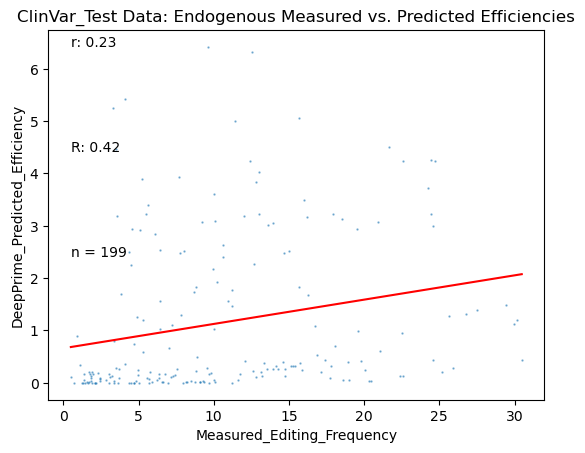

In [206]:
plt.scatter(x, y, s= 0.5, alpha=0.5)

# for gene, color in color_mapping.items():
#     plt.scatter(x[df_input['Gene'] == gene], y[df_input['Gene'] == gene], 
#                 s=10, c=color, label=gene)

# Add labels and title
plt.xlabel('Measured_Editing_Frequency')
plt.ylabel('DeepPrime_Predicted_Efficiency')
plt.title('ClinVar_Test Data: Endogenous Measured vs. Predicted Efficiencies')
# plt.legend(title='Gene', loc = 'lower right')



plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', label='Regression Line (Pearson)')


plt.text(min(x), max(y), f"r: {pearson_corr:.2f}", fontsize=10)

# Annotate Spearman correlation coefficient
plt.text(min(x), max(y)-2, f"R: {spearman_corr:.2f}", fontsize=10)

plt.text(min(x), max(y)-4, "n = "+ str(len(concatenated)), fontsize=10)


# Show the plot
plt.show()